In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Select Mode:
1️⃣  Compare two images from Google Drive
2️⃣  Upload manually (one side-by-side image or two separate images)
Enter 1 or 2: 1
📂 Using images from Google Drive...
🎨 Detected: Cartoon/Digital Art Mode (High Sensitivity)


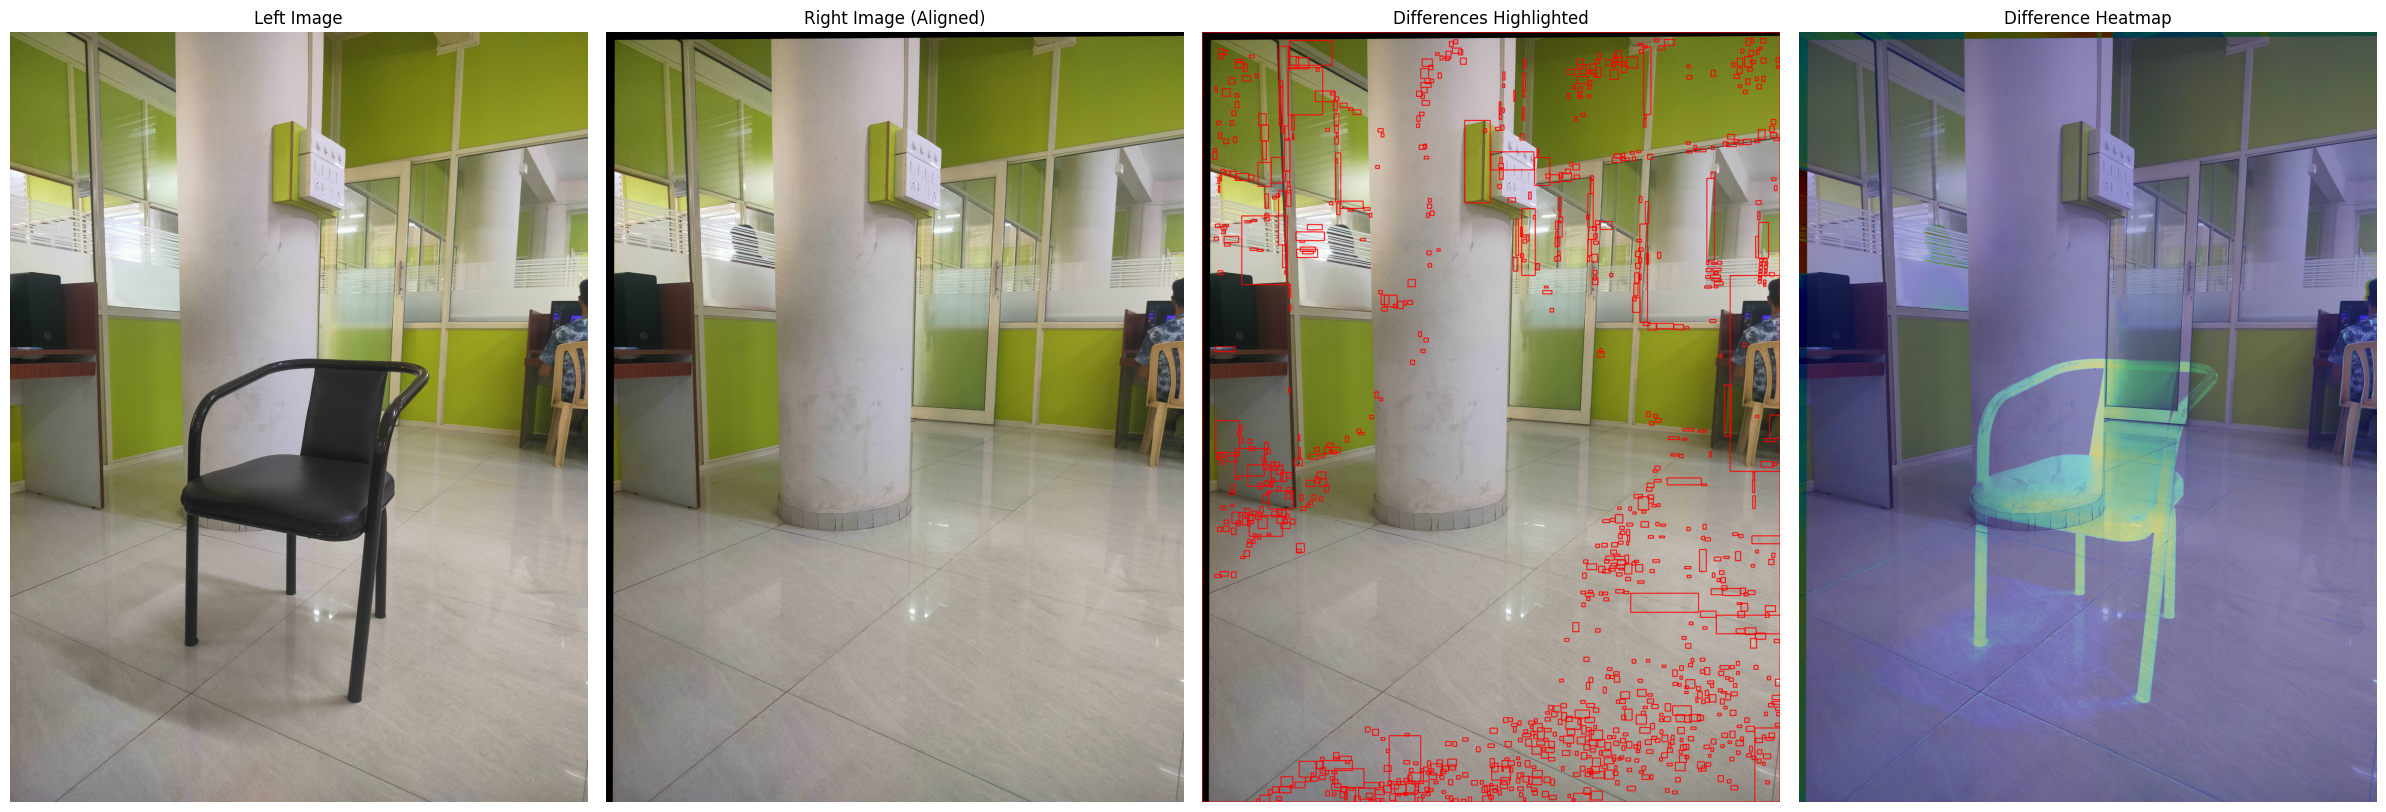

🕵️ Detected 1036 significant differences!


In [ ]:
# ========================================
# Step 1: Install & Import Libraries
# ========================================
!pip install opencv-python matplotlib

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import files

# ========================================
# Step 2: Select Mode
# ========================================
print("Select Mode:")
print("1️⃣  Compare two images from Google Drive")
print("2️⃣  Upload manually (one side-by-side image or two separate images)")
mode = int(input("Enter 1 or 2: "))

# ========================================
# Step 3: Load Images
# ========================================
left_img = None
right_img = None

if mode == 1:
    print("📂 Using images from Google Drive...")

    # 🔹 Replace with your actual Drive paths
    img1_path = "/content/drive/MyDrive/Opencv_Project/1.jpg"
    img2_path = "/content/drive/MyDrive/Opencv_Project/2.jpg"

    # Check files exist
    if not os.path.exists(img1_path):
        print(f"❌ Error: Left image path does not exist: {img1_path}")
        raise SystemExit
    if not os.path.exists(img2_path):
        print(f"❌ Error: Right image path does not exist: {img2_path}")
        raise SystemExit

    left_img = cv2.imread(img1_path)
    right_img = cv2.imread(img2_path)

    # Add check to ensure images are loaded correctly
    if left_img is None:
        print(f"❌ Error: Left image not loaded. Check path: {img1_path}")
        raise SystemExit
    if right_img is None:
        print(f"❌ Error: Right image not loaded. Check path: {img2_path}")
        raise SystemExit

    right_img = cv2.resize(right_img, (left_img.shape[1], left_img.shape[0]))

elif mode == 2:
    print("\n📸 Choose upload type:")
    print("1️⃣  One image (contains both sides side-by-side)")
    print("2️⃣  Two separate images")
    sub_mode = int(input("Enter 1 or 2: "))

    if sub_mode == 1:
        print("📤 Upload the side-by-side image:")
        uploaded = files.upload()
        if len(uploaded) == 0:
            print("❌ No file uploaded.")
            raise SystemExit
        img_path = list(uploaded.keys())[0]
        image = cv2.imread(img_path)

        if image is None:
            print("❌ Invalid image file.")
            raise SystemExit

        # Resize to standard width (if too small/large adjust as needed)
        image = cv2.resize(image, (800, 400))
        h, w, _ = image.shape
        left_img = image[:, :w//2]
        right_img = image[:, w//2:]

    elif sub_mode == 2:
        print("📤 Upload the FIRST image:")
        uploaded1 = files.upload()
        if len(uploaded1) == 0:
            print("❌ No first file uploaded.")
            raise SystemExit
        print("📤 Upload the SECOND image:")
        uploaded2 = files.upload()
        if len(uploaded2) == 0:
            print("❌ No second file uploaded.")
            raise SystemExit

        img1_path = list(uploaded1.keys())[0]
        img2_path = list(uploaded2.keys())[0]

        left_img = cv2.imread(img1_path)
        right_img = cv2.imread(img2_path)

        if left_img is None or right_img is None:
            print("❌ Invalid images uploaded.")
            raise SystemExit

        right_img = cv2.resize(right_img, (left_img.shape[1], left_img.shape[0]))
    else:
        print("❌ Invalid choice.")
        raise SystemExit
else:
    print("❌ Invalid mode selected.")
    raise SystemExit

# At this point we must have two images
if left_img is None or right_img is None:
    print("❌ Unexpected error: images not loaded.")
    raise SystemExit

# ========================================
# Step 4: Optional Alignment (for real-life photos)
# ========================================
enable_alignment = True  # Recommended for photos

gray_left = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY)
gray_right = cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)

aligned_right = right_img.copy()

if enable_alignment:
    orb = cv2.ORB_create(1000)
    kp1, des1 = orb.detectAndCompute(gray_left, None)
    kp2, des2 = orb.detectAndCompute(gray_right, None)

    # If descriptors missing, skip alignment
    if des1 is None or des2 is None or len(kp1) < 4 or len(kp2) < 4:
        print("⚠️ ORB didn't find enough descriptors/keypoints — skipping alignment.")
        aligned_right = right_img.copy()
    else:
        try:
            bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
            matches = bf.match(des1, des2)
            matches = sorted(matches, key=lambda x: x.distance)
            if len(matches) > 10:
                src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
                dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1,1,2)
                M, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC,5.0)
                if M is not None:
                    aligned_right = cv2.warpPerspective(right_img, M, (left_img.shape[1], left_img.shape[0]))
                else:
                    print("⚠️ Homography failed, proceeding without alignment.")
                    aligned_right = right_img.copy()
            else:
                print("⚠️ Not enough matches for robust alignment. Proceeding without alignment.")
                aligned_right = right_img.copy()
        except Exception as e:
            print(f"⚠️ Alignment error: {e}. Proceeding without alignment.")
            aligned_right = right_img.copy()
else:
    aligned_right = right_img.copy()

# ========================================
# Step 5: Auto Sensitivity (Cartoon vs Real-Life)
# ========================================
def estimate_detail_level(image):
    """Estimate detail level via edge density."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    edge_ratio = np.sum(edges > 0) / edges.size
    return edge_ratio

detail_left = estimate_detail_level(left_img)
detail_right = estimate_detail_level(aligned_right)
avg_detail = (detail_left + detail_right) / 2

if avg_detail > 0.08:
    blur_size = (5,5)
    threshold_value = 30
    min_contour_area = 200
    print("🖼️ Detected: Real-Life Photo Mode (Balanced Sensitivity)")
else:
    blur_size = (3,3)
    threshold_value = 15
    min_contour_area = 120
    print("🎨 Detected: Cartoon/Digital Art Mode (High Sensitivity)")

# ========================================
# Step 6: Detect Differences
# ========================================
diff_color = cv2.absdiff(left_img, aligned_right)
diff_gray = cv2.cvtColor(diff_color, cv2.COLOR_BGR2GRAY)
diff_gray = cv2.GaussianBlur(diff_gray, blur_size, 0)

_, thresh = cv2.threshold(diff_gray, threshold_value, 255, cv2.THRESH_BINARY)
kernel = np.ones((3,3), np.uint8)
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
thresh = cv2.dilate(thresh, kernel, iterations=2)

# robust findContours handling for different OpenCV versions
contours_info = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if len(contours_info) == 2:
    contours = contours_info[0]
else:
    contours = contours_info[1]

highlighted = aligned_right.copy()

for contour in contours:
    if cv2.contourArea(contour) > min_contour_area:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(highlighted, (x, y), (x+w, y+h), (0,0,255), 3)

# ========================================
# Step 7: Generate Heatmap + Combined Output
# ========================================
# ensure diff_gray is 8-bit single channel (it should be)
diff_gray_8u = cv2.normalize(diff_gray, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
heatmap = cv2.applyColorMap(diff_gray_8u, cv2.COLORMAP_JET)
heatmap = cv2.addWeighted(aligned_right, 0.7, heatmap, 0.3, 0)

# ========================================
# Step 8: Visualization (All 4 Side by Side)
# ========================================
plt.figure(figsize=(24, 8))
plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB))
plt.title("Left Image"); plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(cv2.cvtColor(aligned_right, cv2.COLOR_BGR2RGB))
plt.title("Right Image (Aligned)"); plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(cv2.cvtColor(highlighted, cv2.COLOR_BGR2RGB))
plt.title("Differences Highlighted"); plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB))
plt.title("Difference Heatmap"); plt.axis('off')

plt.tight_layout()
plt.show()

# ========================================
# Step 9: Summary
# ========================================
num_differences = sum(1 for c in contours if cv2.contourArea(c) > min_contour_area)
print(f"🕵️ Detected {num_differences} significant differences!")
